In [50]:

question = "What is the main benefit of using open-source embedding models?" 
ai_answer = langsmith_rag(question)
print(ai_answer)

<think>
Okay, so I need to figure out the main benefit of using open-source embedding models. Let me start by recalling what I know about embeddings and open-source models. 

Embeddings are a way to represent text (or other data) as vectors in a high-dimensional space, which can then be used for various NLP tasks like semantic search, clustering, or classification. Open-source means that the models are freely available for anyone to use, modify, and distribute. 

The context provided mentions Hugging Face as a provider of open-source models for embeddings. It also notes that these models can be run locally or via an API. So, one benefit could be cost-effectiveness since open-source models are free. 

Another point is customization. Since the models are open-source, users can tweak them to fit specific needs, which might not be possible with proprietary models. This could be especially useful for domain-specific applications where a general model might not perform well. 

Additionally, 

In [35]:
from langsmith import RunTree
from groq import Groq
from typing import List
import nest_asyncio
from utils_hf_embeddings import get_hf_vector_db_retriever 
import os 

os.environ["GROQ_API_KEY"] = "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"
groq_client = Groq()r
retriever = get_hf_vector_db_retriever() 

def retrieve_documents(parent_run: RunTree, question: str):
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [ 
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    groq_response = call_groq(child_run, messages)
    child_run.end(outputs={"groq_response": groq_response})
    child_run.post()
    return groq_response

def call_groq(
    parent_run: RunTree, messages: List[dict], model: str = "deepseek-r1-distill-llama-70b", temperature: float = 0.0
) -> str:
    child_run = parent_run.create_child(
        name="Groq Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    groq_response = groq_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    child_run.end(outputs={"groq_response": groq_response})
    child_run.post()
    return groq_response

def langsmith_rag(question: str):
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output

Loading FAISS vector database from faiss_index_hf with Hugging Face embeddings...
FAISS vector database loaded.


In [49]:

import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled()

False

In [48]:

from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)


False

In [47]:

from langsmith import trace 

messages = [
    {
        "role": "user",
        "content": "How many legs does a cat have?"
    }
]

with trace("Groq Direct Call", run_type="llm", extra={"metadata": {"foo": "bar"}}) as t:
    response = groq_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )
    
    t.end(outputs={"response": response})
    print(response.choices[0].message.content) 

<think>
Okay, so I need to figure out how many legs a cat has. Hmm, I'm pretty sure cats are animals, and most animals have legs, but I'm not exactly sure about the exact number. Let me think about what I know about cats.

First, I remember seeing cats in pictures and in real life. They have this typical posture, usually sitting or walking on the ground. I think they have four legs because when I look at a cat, I can see two in the front and two in the back. Wait, but sometimes when a cat is sitting, it's a bit hard to see all the legs clearly because they might be tucked under the body.

Let me try to visualize a cat. So, from the front, a cat has two legs on the left and two on the right, making four in total. But I'm not entirely certain. Maybe I should think about other animals. Dogs, for example, have four legs too. So, maybe cats are similar. But wait, are there any animals that have a different number of legs? Like, I know spiders have eight legs, but that's different because th

In [43]:
question = "How does Hugging Face contribute to NLP?"
ai_answer = langsmith_rag_with_wrap_groq(question)
print(ai_answer)


<think>
Okay, so I need to figure out how Hugging Face contributes to NLP. Let me start by recalling what I know about Hugging Face. From the context provided, it mentions that Hugging Face offers open-source models for various NLP tasks, including embeddings. These models can be run locally or via their inference API. 

Hmm, so Hugging Face provides models, which is a big part of NLP. But what else? The context also talks about LangChain, which is a framework for building applications with language models. It enables context-aware, reasoning, and acting applications. Wait, but the question is about Hugging Face, not LangChain.

So, focusing back on Hugging Face. They provide models, which is key because without good models, NLP tasks would be harder. They also offer these models through an API, making it easier for developers to use without having to host the models themselves. Plus, the models can be run locally, which gives flexibility depending on the use case.

Additionally, Huggi

In [42]:

import groq
from typing import List
import nest_asyncio
from utils_hf_embeddings import get_hf_vector_db_retriever 
import os 

MODEL_PROVIDER = "groq"
MODEL_NAME = "deepseek-r1-distill-llama-70b"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

os.environ["GROQ_API_KEY"] = "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"
groq_client = groq.Groq()
retriever = get_hf_vector_db_retriever() 

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_groq(messages)

@traceable
def call_groq(
    messages: List[dict],
) -> str:
    return groq_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_groq(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

Loading FAISS vector database from faiss_index_hf with Hugging Face embeddings...
FAISS vector database loaded.


In [41]:

question = "What is the primary purpose of LangChain?" 
ai_answer = langsmith_rag(question)
print(ai_answer)

<think>
Okay, I'm trying to figure out the primary purpose of LangChain. I remember seeing some context provided earlier about it. Let me go through that again. 

The context mentions that LangChain is a framework for developing applications powered by language models. It enables applications that are context-aware, reason, and can act. So, it's used for building apps with these advanced capabilities.

Wait, the user's question is asking for the primary purpose, so I should focus on what it's mainly used for. From the context, it's clear that LangChain is a framework that helps create applications using language models, making them context-aware and capable of reasoning and acting.

I don't see any other details about its other purposes, so the main purpose must be to provide the infrastructure for such applications. I should keep the answer concise and within three sentences.
</think>

The primary purpose of LangChain is to provide a framework for developing applications powered by la

In [40]:
from langsmith import traceable, trace
from groq import Groq
from typing import List
import nest_asyncio
from utils_hf_embeddings import get_hf_vector_db_retriever 
import os 

MODEL_PROVIDER = "groq"
MODEL_NAME = "deepseek-r1-distill-llama-70b"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

os.environ["GROQ_API_KEY"] = "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" 
groq_client = Groq()
retriever = get_hf_vector_db_retriever() 

@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    response = call_groq(messages)
    return response

@traceable
def call_groq(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = groq_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

Loading FAISS vector database from faiss_index_hf with Hugging Face embeddings...
FAISS vector database loaded.


In [39]:
#cell 3
question = "Can tracing be set up when the code is running in langsmith?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': 'Can tracing be set up when the code is running in langsmith?',
 'messages': [HumanMessage(content='Can tracing be set up when the code is running in langsmith?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="<think>\nOkay, so the user is asking if tracing can be set up when the code is running in Langsmith. I don't have any specific information about Langsmith in the context provided. The context talks about LangChain, Hugging Face, and FAISS, but nothing about Langsmith. Since I don't have details on Langsmith's features or capabilities, I can't confirm whether tracing is possible there. I should let the user know that I don't have the answer based on the provided context.\n</think>\n\nI don't know.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 165, 'total_tokens': 276, 'completion_time': 0.47511181, 'prompt_time': 0.029352574, 'queue_time': 0.0420559, 'total_time': 0.504464384}, 'model_name': 'd

Loading FAISS vector database from faiss_index_hf with Hugging Face embeddings...
FAISS vector database loaded.


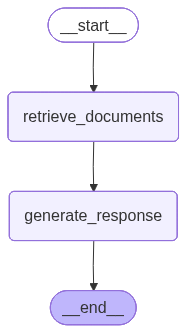

In [38]:

import nest_asyncio
nest_asyncio.apply() 

import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils_hf_embeddings import get_hf_vector_db_retriever, RAG_PROMPT 
import os 

os.environ["GROQ_API_KEY"] = "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" 

retriever = get_hf_vector_db_retriever()
llm = ChatGroq(model_name="deepseek-r1-distill-llama-70b", temperature=0)

class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}


graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

In [37]:

from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

False